Feature extraction is a critical step in computer vision that involves identifying and isolating key patterns or characteristics within an image to be used for various tasks like object recognition, classification, and detection. The VGG16 model, a Convolutional Neural Network (CNN) developed by the Visual Geometry Group at Oxford, is widely used for feature extraction due to its simplicity and powerful architecture. `VGG16 has 16 layers, including 13 convolutional layers and 3 fully connected layers`, and it uses small `3x3` filters to capture spatial hierarchies effectively.

VGG16 processes an image through its convolutional layers, which apply filters to learn spatial features, such as edges, textures, and patterns, at different levels of granularity. Each convolutional layer is followed by a Rectified Linear Unit `(ReLU)` activation, introducing non-linearity, and max pooling layers, which reduce the spatial dimensions while preserving essential features. These processes ensure that VGG16 can extract hierarchical features from low-level textures to high-level representations.

The model is pretrained on large datasets like ImageNet, making it a reliable tool for transfer learning. By freezing its convolutional layers and adding custom layers for specific tasks, users can leverage its learned features for new datasets. VGG16’s regular structure, depth, and computational efficiency make it an industry favorite for applications like image classification and object detection. Although computationally intensive compared to modern architectures, its robust performance and versatility ensure its continued relevance in deep learning workflows.

# **Cell 1: Importing Required Libraries**

This cell imports the essential libraries and modules needed for our project:

- **Matplotlib**: A library used for plotting and visualizing data.
- **NumPy**: A library for numerical computations and handling arrays.
- **OpenCV (cv2)**: A library for computer vision tasks, such as image processing and manipulation.
- **PyTorch Modules**:
  - `torch.nn`: Provides building blocks to define neural networks.
  - `torch.optim`: Contains optimization algorithms like SGD and Adam.
  - `torch`: The core library for handling tensors and automatic differentiation.
  - `torch.nn.functional`: Includes utility functions for neural network operations.
  - `torchsummary`: Used to print a summary of the neural network model, including the layer details and parameter count.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F
from torchsummary import summary

# **Cell 2: Loading, Resizing, and Displaying an Image**

This cell defines a function to load, resize, and display an image using OpenCV and Matplotlib.

### Steps Performed:
1. **Function Definition (`load_resize_display`)**:
   - **Inputs**:
     - `image_path`: Path to the input image file.
     - `new_width`: The desired width (and height, since the image is resized to a square).
   - **Process**:
     - The image is loaded using `cv2.imread()`.
     - It is resized to a square of dimensions `(new_width, new_width)` using `cv2.resize()`.
     - Since OpenCV loads images in BGR format, it is converted to RGB using `cv2.cvtColor()` for proper display with Matplotlib.
   - **Output**:
     - The resized RGB image.

2. **Image Loading and Processing**:
   - An example image located at `/content/dog.jpeg` is passed to the `load_resize_display` function with a target size of 224x224 pixels.

3. **Displaying the Image**:
   - The processed image is displayed using `plt.imshow()` from Matplotlib, and the axis is turned off for a cleaner visualization.

### Note:
Replace `'/content/dog.jpeg'` with the path to your image if using a different file.


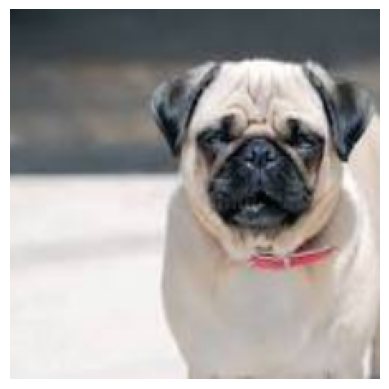

In [7]:
def load_resize_display(image_path, new_width):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (new_width, new_width))
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return resized_image_rgb

image_path = '/content/dog.jpeg'  # Replace with your image path
img = load_resize_display(image_path, 224)
plt.axis('off')
plt.imshow(img)
plt.show()

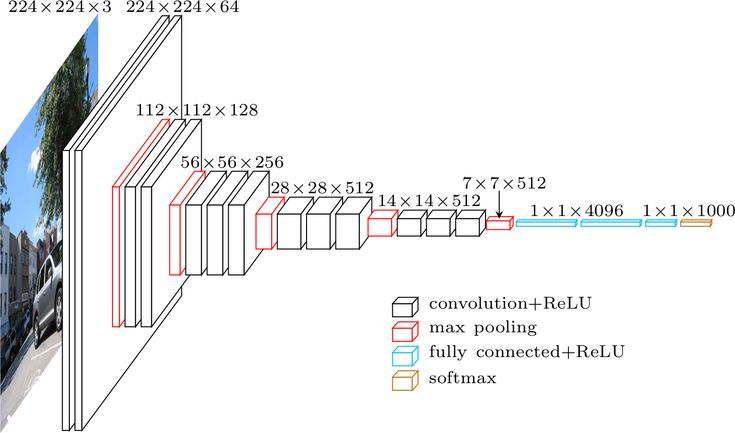

# **Cell 3: Defining the R_CNN Neural Network**

This cell defines a custom convolutional neural network (CNN) class called `R_CNN` using PyTorch's `torch.nn.Module`.

### Key Components:
1. **Initialization (`__init__` method)**:
   - Four convolutional layers (`conv1`, `conv2`, `conv3`, `conv4`) for extracting hierarchical features from the input image.
     - `in_channels` and `out_channels`: Define the input/output dimensions of each convolutional layer.
     - `kernel_size`: Size of the filter (3x3 for all layers).
     - `stride` and `padding`: Control the movement of the filter and border handling.
   - Two fully connected layers (`layer1` and `layer2`):
     - `layer1`: Maps the flattened features to 1000 neurons.
     - `layer2`: Reduces the output to 10 classes (e.g., for classification).
   - Activation functions:
     - **ReLU**: Applies non-linearity after each convolutional and fully connected layer.
     - **Softmax**: Converts the output of `layer2` into probabilities across 10 classes.
   - **MaxPooling (`pool`)**: Reduces spatial dimensions by half (2x2 pooling).

2. **Helper Methods**:
   - **`convolayer`**:
     - Applies convolutional layers sequentially with ReLU activation and max-pooling, progressively reducing the spatial dimensions.
   - **`NN_block`**:
     - Flattens the output of the convolutional layers.
     - Passes it through the fully connected layers with ReLU and Softmax activation.

3. **Forward Propagation (`forward` method)**:
   - Combines the `convolayer` and `NN_block` methods.
   - Returns the final feature map (`x`) from the convolutional layers and the classification output (`y`) from the fully connected layers.

### Purpose:
This model can be used for image classification, where it extracts features from input images using convolutional layers and performs classification using fully connected layers.


In [8]:
class R_CNN(nn.Module):
    def __init__(self):
        super(R_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer1 = nn.Linear(512 * 7 * 7, 1000)
        self.layer2 = nn.Linear(1000, 10)
        self.softmax = nn.Softmax(dim=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def convolayer(self, data):
      x = self.relu(self.conv1(data))
      x = self.pool(self.relu(self.conv2(x)))
      x = self.pool(self.relu(self.conv3(x)))
      x = self.pool(self.relu(self.conv4(x)))
      x = self.pool(self.pool(x))
      return x

    def NN_block(self, data):
      x = torch.flatten(data, 1)
      x = F.relu(self.layer1(x))
      x = self.softmax(self.layer2(x))
      return x

    def forward(self, x):
      x = self.convolayer(x)
      y = self.NN_block(x)
      return x, y


# **Cell 4: Model Summary with Input Dimensions**

This cell initializes the `R_CNN` model and displays a detailed summary of its architecture using the `torchsummary` library.

### Key Steps:
1. **Model Initialization**:
   - The `R_CNN` model is instantiated using `model = R_CNN()`.

2. **Model Summary**:
   - The `summary()` function from `torchsummary` is used to print a detailed layer-by-layer summary of the model.
   - **Input Size**: `(3, 224, 224)` is provided as the input dimensions, representing:
     - `3`: The number of color channels (RGB).
     - `224 x 224`: The spatial dimensions of the input image.

### Output of the Summary:
- **Layer Details**: The summary lists all layers in the `R_CNN` model, including convolutional layers, pooling layers, and fully connected layers.
- **Output Shapes**: For each layer, the output dimensions are shown, reflecting the transformations performed by the model.
- **Parameter Count**:
  - **Trainable Parameters**: Parameters that will be optimized during training.
  - **Non-Trainable Parameters**: Parameters that remain constant (none in this case).

### Purpose:
The summary provides a clear understanding of the model's architecture, its layer-by-layer operations, and the total number of parameters, helping ensure that the model is correctly implemented before proceeding to training.


In [9]:
model = R_CNN()
summary(model, input_size= (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3        [-1, 128, 224, 224]          73,856
              ReLU-4        [-1, 128, 224, 224]               0
         MaxPool2d-5        [-1, 128, 112, 112]               0
            Conv2d-6        [-1, 256, 112, 112]         295,168
              ReLU-7        [-1, 256, 112, 112]               0
         MaxPool2d-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 512, 56, 56]       1,180,160
             ReLU-10          [-1, 512, 56, 56]               0
        MaxPool2d-11          [-1, 512, 28, 28]               0
        MaxPool2d-12          [-1, 512, 14, 14]               0
        MaxPool2d-13            [-1, 512, 7, 7]               0
           Linear-14                 [-

# **Cell 5: Image Preprocessing for the Model (Optimized)**

This cell demonstrates an optimized approach to preprocess the image and prepare it for input to the neural network.

### Key Steps:
1. **Transforming the Image**:
   - The image (`img`) is directly converted to a NumPy array using `np.array(img)`.
   - The array is transposed using `.T` to rearrange the dimensions into the order `(channels, height, width)`.

2. **Reshaping**:
   - The array is reshaped into the format `(1, 3, 224, 224)`:
     - `1`: Batch size (single image).
     - `3`: Number of channels (Red, Green, Blue).
     - `224 x 224`: Image dimensions.

3. **Conversion to PyTorch Tensor**:
   - The reshaped NumPy array is converted to a PyTorch tensor using `torch.from_numpy(fin)`.

4. **Shape Verification**:
   - The shape of the tensor is printed using `print(fin.shape)`, confirming it matches the expected format `(1, 3, 224, 224)`.

### Purpose:
This streamlined approach reduces intermediate steps while ensuring that the image is correctly formatted for the `R_CNN` model. The tensor is ready to be passed as input for further processing or inference.


In [27]:
fin = (np.array(img, dtype='float32').T).reshape(1,3,224,224)
fin = torch.from_numpy(fin)
print(fin.shape)

torch.Size([1, 3, 224, 224])


# **Cell 6: Forward Pass through the Model**

This cell demonstrates how to pass the preprocessed input tensor (`fin`) through the `R_CNN` model to obtain the output.

### Key Steps:
1. **Forward Pass**:
   - The preprocessed tensor `fin` is passed through the `R_CNN` model using `a = model(fin)`.
   - The model's `forward` method is executed, returning two outputs:
     - **Index [0]**: Contains the feature maps generated by the convolutional layers (`convolayer`).
     - **Index [1]**: Contains the final classification output (probabilities for 10 classes) generated by the fully connected layers (`NN_block`).

2. **Accessing Outputs**:
   - **Feature Maps**: Stored at `a[0]`, representing the extracted features from the input image.
   - **Classification Output**: Stored at `a[1]`, which contains the class probabilities produced by the Softmax activation in the final layer.

3. **Use Cases**:
   - The feature maps can be visualized or further analyzed to understand how the model processes the input image.
   - The classification output can be used to determine the predicted class of the input image.

### Purpose:
This step connects the preprocessed input image (`fin`) with the trained model (`R_CNN`), enabling feature extraction and classification in a single operation.


In [28]:
a = model(fin) # contining all images in index [0] and final classification output at index [1]

# **Cell 7: Visualizing Feature Maps**

This cell visualizes the feature maps generated by the convolutional layers of the `R_CNN` model. The feature maps are stored in `a[0]`.

### Key Steps:
1. **Iterating Through Feature Maps**:
   - The first output of the model (`a[0]`) contains the feature maps for the input image.
   - Each feature map is iterated over using `for i in a[0]:`.

2. **Creating Figures**:
   - A new figure is created for each set of feature maps using `plt.figure()`.
   - The `figsize` is set to `(12, 18)` to ensure the feature maps are displayed clearly and are large enough to observe details.

3. **Displaying Feature Maps**:
   - For each feature map in the set, a subplot is created using `plt.subplot(32, 16, k + 1)`.
     - `32 x 16` specifies the grid dimensions, with each grid cell containing one feature map.
   - `plt.imshow()` is used to display each feature map in grayscale (`cmap='gray'`).
   - `plt.axis('off')` is used to hide the axes for a cleaner visualization.

4. **Adjusting Spacing**:
   - `plt.subplots_adjust(wspace=0.01, hspace=0.05)` reduces the space between subplots, ensuring the images are compactly displayed.

5. **Displaying the Plot**:
   - `plt.show()` displays the complete figure of feature maps.

### Purpose:
This step provides insight into how the model processes the input image at different convolutional layers, showcasing the learned features at each stage.


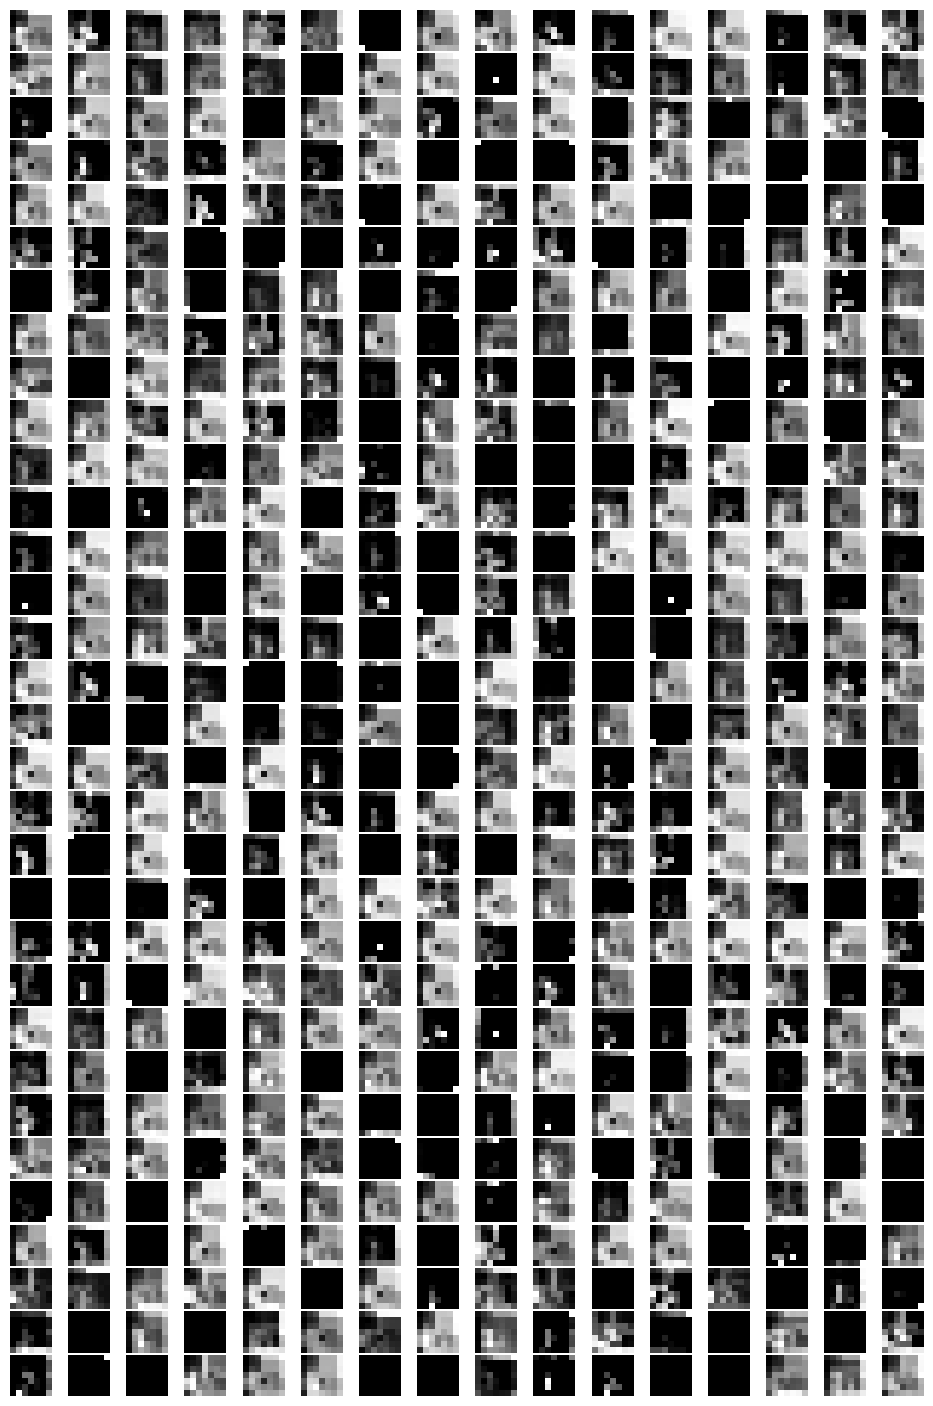

In [29]:
for i in a[0]:
    plt.figure(figsize=(12, 18))  # Increase figure size to make the images larger
    for k, image in enumerate(i):
        plt.subplot(32, 16, k + 1)
        plt.axis('off')
        plt.imshow(image.detach(), cmap='gray')


    # Decrease width spacing and adjust height spacing
    plt.subplots_adjust(wspace=0.01, hspace=0.05)  # Smaller wspace reduces horizontal distance
    plt.show()


### Note:
This code is only for visualizing the features the model extracts from the image and is not for training the model.

If you want to train the model, you can combine this code with your Cats vs. Dogs classification model. You can find the [Cats vs. Dogs classification model notebook here](https://github.com/kanishkkumarsingh2004/Cats_and_Dogs_classification/blob/main/cats_and_dog_classification.ipynb). By combining feature extraction with the classification part, you'll have a complete training pipeline.
